In [173]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.xkcd()
font = cv2.FONT_HERSHEY_SIMPLEX
path = os.path.abspath(os.curdir)
file = r"\video3.mp4"
video = path + file

In [175]:
# Load the image
cap = cv2.VideoCapture(video)
ret, image = cap.read()

if image.shape[0] > image.shape[1]: image = np.rot90(image)
scale = 2 if image.shape[0] > 1000 else 1
image = cv2.resize(image, (int(image.shape[1]/scale), int(image.shape[0]/scale)), interpolation = cv2.INTER_AREA)

# Create box variables
C1, C2, displayBox = (0, 0), (0, 0), False

def calibrateBox(event, x, y, flags, params):
    """Function for calibrating the bounds of the box"""
    global C1, C2, displayBox
    img = image.copy()
  
    # Check for input
    if event == cv2.EVENT_LBUTTONDOWN: C1 = (x, y); displayBox = True
    if event == cv2.EVENT_LBUTTONUP: C2 = (x, y); displayBox = False
    if event == cv2.EVENT_MOUSEMOVE:
        if displayBox:
            C2 = (x, y)

            # Render Box
            mid = [int(min(C1[0], C2[0]) + np.abs((C2[0] - C1[0])/2)),
                         int(min(C1[1], C2[1]) + np.abs((C2[1] - C1[1])/2))]
            length = [np.abs(C1[0] - C2[0]), np.abs(C1[1] - C2[1])]
            if length[0] > length[1] * 1.2 and length[1] > length[0]*0.3:
                cv2.line(img, (mid[0], min(C1[1], C2[1])), (mid[0], max(C1[1], C2[1])), (50, 200, 50), 4)
                cv2.putText(img, f"A", (int(mid[0] - length[0]*0.29),int(mid[1]+length[1]/15)), font, length[0]/200, (0, 150, 250), int(length[0]/100))
                cv2.putText(img, f"B", (int(mid[0] + length[0]*0.2),int(mid[1]+length[1]/15)), font, length[0]/200, (0, 150, 250), int(length[0]/100))
            if length[1] > length[0] * 1.2 and length[0] > length[1]*0.3:
                cv2.line(img, (min(C1[0], C2[0]), mid[1]), (max(C1[0], C2[0]), mid[1]), (50, 200, 50), 4)
                cv2.putText(img, f"A", (int(mid[0]-length[0]/15), int(mid[1] - length[1]*0.2)), font, length[1]/200, (0, 150, 250), int(length[1]/100))
                cv2.putText(img, f"B", (int(mid[0]-length[0]/15), int(mid[1] + length[1]*0.25)), font, length[1]/200, (0, 150, 250), int(length[1]/100))
            cv2.rectangle(img, C1, C2, (50, 200, 50), 5)
            cv2.imshow('image', img)
  

# Display the image
cv2.imshow('image', image)
cv2.setMouseCallback('image', calibrateBox)
cv2.waitKey(0); cv2.destroyAllWindows()

box = np.array([min(C1[0], C2[0]), max(C1[0], C2[0]), min(C1[1], C2[1]), max(C1[1], C2[1])])*scale

In [182]:
A, B, V, N = [], [], 64, 11

thresh = 1.2

interpolation = 1

ballSize = np.abs(box[0] - box[1])/30

cap = cv2.VideoCapture(video)

# Read until video is completed
i = 0
while(cap.isOpened()):
    ret, frame = cap.read() 
    i += 1

    if ret:
        if frame.shape[0] > frame.shape[1]: frame = np.rot90(frame)
        frame = np.ascontiguousarray(frame, dtype=np.uint8)
        frame = frame[box[2]: box[3], box[0]: box[1]]
        
        
        blurred = cv2.blur(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), (1, 1))
        circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1.6*thresh, ballSize, param1 = 50*thresh,
        param2 = 50*thresh**-1, minRadius = int(ballSize*0.8), maxRadius = int(ballSize*1.2))

        if circles is not None:
            if len(circles[0, :]) >= N and i % interpolation == 0:
                n = 0
                a, b = [], []
                for pt in circles[0, : ]:
                    x, y, r = int(pt[0]), int(pt[1]), int(pt[2])

                    C = frame[y-r:y+r, x-r:x+r]
                    BGR = C.mean(axis=0).mean(axis=0)
                    if BGR[0] < 150: pass
                    elif BGR[2] < 120: 
                        cv2.circle(frame, (x, y), r, (100, 50, 0), 4)
                        cv2.circle(frame, (x, y), 1, (100, 50, 0), 4)
                        if x < frame.shape[1]/2: a.append("Blue")
                        else: b.append("Blue")
                        n +=1
                    else:
                        cv2.circle(frame, (x, y), r, (50, 50, 50), 4)
                        cv2.circle(frame, (x, y), 1, (50, 50, 50), 4)
                        if x < frame.shape[1]/2: a.append("White")
                        else: b.append("White")

                        n +=1               
                    if n == N: break

                A.append(a)
                B.append(b)

                if n == N:
                    cv2.putText(frame, f"A", (30, 75), font, 2, (0, 0, 250), 4)
                    cv2.putText(frame, f"B", (frame.shape[1]-60, 75), font, 2, (0, 0, 250), 4)
                    cv2.imshow('Frame',frame)


    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break
 
# When everything done, release the video capture object
cap.release()
cv2.destroyAllWindows()

# plt.hist(LEFT, bins=range(1, 11), alpha=0.5, label='LEFT')

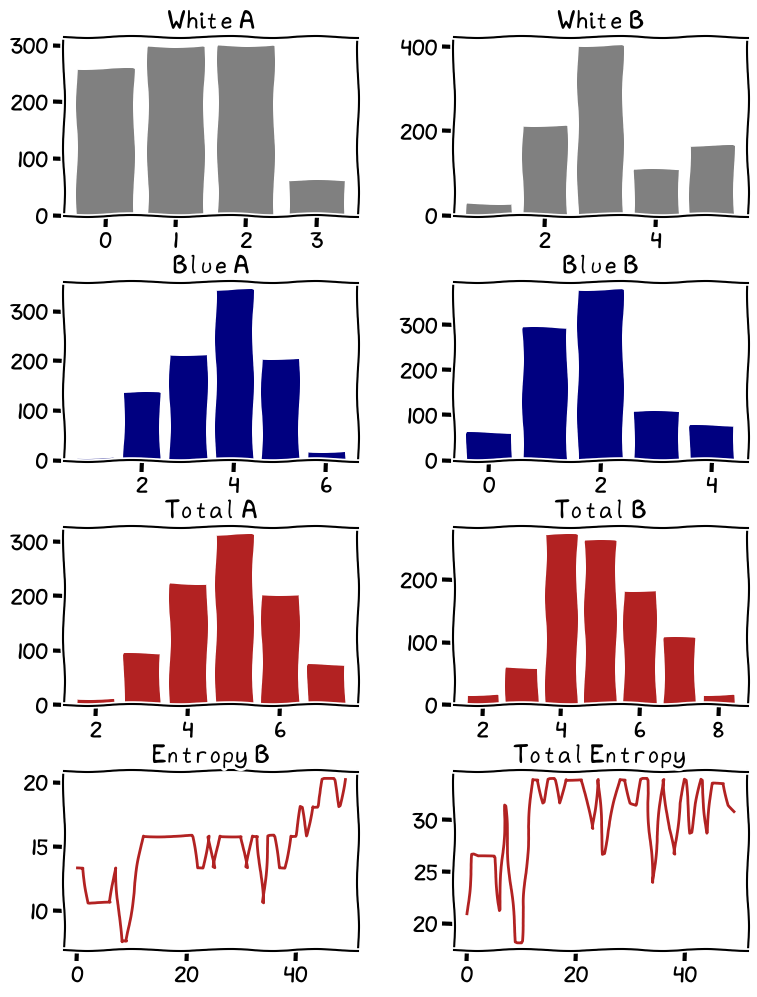

In [187]:
from scipy.special import factorial

ohm = lambda N: factorial(V) / (factorial(N) * factorial(V - N))

fig, axs = plt.subplots(4, 2, figsize=(8, 10))
plt.tight_layout()

blueA, blueB = np.array([]), np.array([])
whiteA, whiteB = np.array([]), np.array([])
totalA, totalB = np.array([]), np.array([])

for i in range(len(A)):
    blueA = np.append(blueA, A[i].count("Blue"))
    blueB = np.append(blueB, B[i].count("Blue"))

    whiteA = np.append(whiteA, A[i].count("White"))
    whiteB = np.append(whiteB, B[i].count("White"))

    
totalA = whiteA + blueA
totalB = whiteB + blueB

data = [whiteA, whiteB, blueA, blueB, totalA, totalB]
titles = ["White A", "White B",  "Blue A",  "Blue B", "Total A", "Total B"]

for i, ax in enumerate(axs.flat[:6]):
    labels, counts = np.unique(data[i], return_counts=True)
    ax.bar(labels, counts, color = ["grey", "navy", "firebrick"][int(np.floor(i/2))])
    ax.set_title(titles[i])


axs.flat[6].plot(np.log(ohm(totalB))[:50], color="firebrick")
axs.flat[6].set_title("Entropy B")

axs.flat[7].plot(np.log(ohm(totalB) * ohm(totalA))[:50], color="firebrick")
axs.flat[7].set_title("Total Entropy")

plt.show()